In [15]:
# Code script to recreate the figures in Marvin et al. (2024), in Geophysical Research Letters

# [paper citation here]

In [ ]:
#load packages
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp

from scipy import stats  # Import the stats module from SciPy
# from scipy.stats import curve_fit

import statsmodels.api as sm

import rasterio

import cv2

import geopandas as gpd
import os
os.environ["PROJ_LIB"] = "/Users/michaelmarvin/opt/anaconda3/pkgs/basemap-data-1.3.2-pyhd3eb1b0_1/site-packages/mpl_toolkits/basemap_data/epsg"; #fixr
from mpl_toolkits.basemap import Basemap

In [2]:
#path to gridded data
path = "/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/grid50km_final.csv"

df = pd.read_csv(path)

In [3]:
#path to raw gridded data
path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/marvin_etal_2024_data_RAW.csv'

df = pd.read_csv(path)

# creating new column for degrees W longitude from 0-360
df['LONG_W'] = df['LONG'].copy()

# transform to degrees W longitude from 0-360
df.loc[(df['LONG'] >= 0) & (df['LONG'] <= 180), 'LONG_W'] = df.loc[(df['LONG'] >= 0) & (df['LONG'] <= 180), 'LONG_W'] * -1 + 360
df.loc[(df['LONG'] >= -180) & (df['LONG'] < 0), 'LONG_W'] = -df.loc[(df['LONG'] >= -180) & (df['LONG'] < 0), 'LONG_W']


df['INDEX'] = np.arange(df.shape[0])

# shape of df
num_columns = 324
num_rows = 162

# calculate ROW, COLUMN indices
df['ROW'] = df.index // num_columns
df['COLUMN'] = df.index % num_columns

# used to identify grid cells that are fully surrounded by grid cells with data
# this is to remove grid cells along the edge of dune fields
def get_neighbors(row, col, num_rows, num_columns):
    neighbors = [
        (row-1, col-1), (row-1, col), (row-1, col+1),
        (row, col-1),                (row, col+1),
        (row+1, col-1), (row+1, col), (row+1, col+1)
    ]
    # filter out those edge grid cells
    neighbors = [(r, c) for r, c in neighbors if 0 <= r < num_rows and 0 <= c < num_columns]
    return neighbors

# add column of EDGE
df['EDGE'] = 0

# verify a given cell hasall 8 neighbors
for index, row in df.iterrows():
    row_index = row['ROW']
    col_index = row['COLUMN']
    
    neighbors = get_neighbors(row_index, col_index, num_rows, num_columns)
    
    # if not, set EDGE to 1
    if len(neighbors) < 8:
        df.at[index, 'EDGE'] = 1

# create copy of df to ensure consistency
df_copy = df.copy()

# running list of the rows in the df to drop
rows_to_drop = []

# go through all the data
for index, row in df_copy.iterrows():
    if row['EDGE'] == 1:
        continue  # skip edge cells
    
    row_index = row['ROW']
    col_index = row['COLUMN']
    
    neighbors = get_neighbors(row_index, col_index, num_rows, num_columns)
    
    # checking neighboring grid cells
    all_neighbors_positive = all(
        df_copy[(df_copy['ROW'] == r) & (df_copy['COLUMN'] == c)]['LAMBDA_M'].values[0] > 0
        for r, c in neighbors
        if not df_copy[(df_copy['ROW'] == r) & (df_copy['COLUMN'] == c)].empty
    )
    
    # identify rows to drop
    if not all_neighbors_positive:
        rows_to_drop.append(index)

# drop rows
df.drop(rows_to_drop, inplace=True)

# keep  original ROW and COLUMN indices
df = df.reset_index(drop=True)

# display first few rows
print(df.head())

   Id  Shape_Leng  sum_Length  Polyline_C  Point_Coun  Shape_Le_1  \
0   0    200000.0         0.0           0           0    200000.0   
1   0    200000.0         0.0           0           0    200000.0   
2   0    200000.0         0.0           0           0    200000.0   
3   0    200000.0         0.0           0           0    200000.0   
4   0    200000.0         0.0           0           0    200000.0   

     Shape_Area  sum_Area_S  Polygon_Co NAME  ...  RHO  RHO_0  DELTA_RHO  \
0  2.500000e+09         0.0           0  NaN  ...  NaN    NaN        NaN   
1  2.500000e+09         0.0           0  NaN  ...  NaN    NaN        NaN   
2  2.500000e+09         0.0           0  NaN  ...  NaN    NaN        NaN   
3  2.500000e+09         0.0           0  NaN  ...  NaN    NaN        NaN   
4  2.500000e+09         0.0           0  NaN  ...  NaN    NaN        NaN   

        LAT      LONG      LONG_W  INDEX  ROW  COLUMN  EDGE  
0 -89.44373  0.556270  359.443730      0    0       0     1  
1 -8

In [ ]:
# output Supp file
df.to_csv('Supplementary_File_S1.csv', index=False)

# can read in Table S1 here instead of raw if desired

In [6]:
# used to drop physically unlikely data points in case they are not removed when edge cells are removed

# define conditions for row removal
condition1 = df['Polyline_C'] > 1  # more than 1 line per grid
condition2 = df['LAMBDA_M'] > 500  # spacing greater than 500 m
condition3 = df['DELTA_RHO'] < 0.2e8  
condition4 = df['DELTA_RHO'] > 0 
condition5 = df['RHO'] < 0.0025  # defect density < 0.0025
condition6 = df['LAMBDA_M'] < 37500  # spacing less than than 37500 m

# combine
combined_condition = condition1 & condition2 & condition3 & condition4 & condition5 & condition6

# filter and get new df called filtered_df
filtered_df = df[combined_condition]


In [7]:
# read in raw crest data
crest_path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/marvin_etal_2024_crestlines_RAW.csv'
crest_data = pd.read_csv(crest_path)


crest_summarize = crest_data.groupby('NAME')[['LENGTH_M']].sum()
crest_summarize['N_CREST'] = crest_data.groupby('NAME')[['LENGTH_M']].count()
crest_summarize['MAX_L'] = crest_data.groupby('NAME')[['LENGTH_M']].max()
crest_summarize['RHO'] = crest_summarize['N_CREST'] / crest_summarize['LENGTH_M']

spacing_summarize = filtered_df.groupby('NAME')[['LAMBDA_M']].median()

dunefields = pd.merge(crest_summarize, spacing_summarize, on=['NAME','NAME'])
dunefields['RHO_0'] = np.exp(4.4946) * dunefields['LAMBDA_M']**(-2.2375)
dunefields['DELTA_RHO'] = dunefields['RHO'] / dunefields['RHO_0']

print(crest_data)
print(dunefields)

        OID_  CaseField       Lat         Lon       NAME       LENGTH_M
0          0    1075144 -3.404762 -156.077203  SHANGRILA  173516.155004
1          1    1031761 -3.040562 -157.042513  SHANGRILA   87663.626495
2          2    1055129 -3.277847 -156.522543  SHANGRILA   66231.335510
3          3    1101275 -3.887412 -155.495759  SHANGRILA  135188.254417
4          4    1023036 -3.108334 -157.236652  SHANGRILA   63941.022200
...      ...        ...       ...         ...        ...            ...
30431  30431          0  0.000000    0.000000      BELET   37445.172364
30432  30432          0  0.000000    0.000000      BELET   24157.048872
30433  30433          0  0.000000    0.000000      BELET   24169.807003
30434  30434          0  0.000000    0.000000      BELET   14944.627983
30435  30435          0  0.000000    0.000000      BELET   26207.437476

[30436 rows x 6 columns]
                         LENGTH_M  N_CREST          MAX_L       RHO  LAMBDA_M  \
NAME      NAME               

In [8]:
#read in patterns data from Marvin et al. (2023) and Ewing et al. (2015)

#Ewing et al. (2015) longitudinal dune data
E_path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/Ewing_et_al_2015_data.xlsx'
E_data = pd.read_excel(E_path)
E_df_prelim = pd.DataFrame(E_data)
E_selected_rows = E_df_prelim[E_df_prelim['TYPE'] == 'Longitudinal']
E_df = pd.DataFrame(E_selected_rows)

#Marvin et al. (2023) longitudinal dune data
Marvin_path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/Marvin_etal_2023_dune_patterns_data.csv'
Marvin_data = pd.read_csv(Marvin_path)
prelim_df = pd.DataFrame(Marvin_data)
M_selected_rows = prelim_df[prelim_df['TYPE'] == 'Longitudinal']
M_df = pd.DataFrame(M_selected_rows)
M_df['RHO'] = M_df['TOT_DUNE'] / (M_df['CREST_LENGTH'] * 1000)

#degraded SAR vs image pattern stats for terrestrial sensitivity analysis
deg_path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/Marvin_etal_2023_dune_patterns_terrestrial_sensitivity_analyses.csv'
deg_data = pd.read_csv(deg_path)
deg_df = pd.DataFrame(deg_data)
deg_df['RHO_0'] = np.exp(4.4946)*deg_df['LAMBDA_M']**(-2.2375)
deg_df['RHO_0_DEG'] = np.exp(4.4946)*deg_df['LAMBDA_M_DEG']**(-2.2375)

deg_df['DELTA_RHO'] = deg_df['RHO'] / deg_df['RHO_0']
deg_df['DELTA_RHO_DEG'] = deg_df['RHO_DEG'] / deg_df['RHO_0_DEG']

In [9]:
#needed for plotting Fig. 3, lambda vs rho

filtered_df_over2k = filtered_df[filtered_df['LAMBDA_M'] > 2000]
filtered_df_under2k = filtered_df[filtered_df['LAMBDA_M'] < 2000]

belet = filtered_df[filtered_df['NAME'] == 'BELET']
fensal = filtered_df[filtered_df['NAME'] == 'FENSAL']
senkyo = filtered_df[filtered_df['NAME'] == 'SENKYO']
shangrila = filtered_df[filtered_df['NAME'] == 'SHANGRILA']

In [ ]:
# MAIN TEXT FIGURES

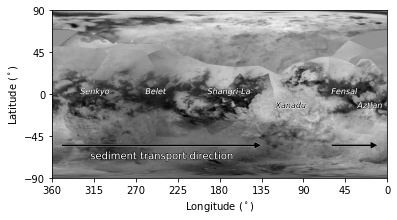

In [10]:
# FIGURE 1A

#read in basemap
ISS_basemap = plt.imread('/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/ISS_mosaic_low_res.tif')
ISS_basemap = cv2.cvtColor(ISS_basemap, cv2.COLOR_BGR2RGB)

#set projection and axes limits
t = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=360, urcrnrlon=0)

im = t.imshow(ISS_basemap[::-1], origin='lower') #, cmap='jet'

# add text
plt.text(330, 0, 'Senkyo', c = 'w', fontsize = 8, style='italic', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
plt.text(260, 0, 'Belet', c = 'w', fontsize = 8, style='italic', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
plt.text(170, 0, 'Shangri-La', c = 'w', fontsize = 8, style='italic', horizontalalignment='center', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
plt.text(60, 0, 'Fensal', c = 'w', fontsize = 8, style='italic', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
plt.text(32, -15, 'Aztlan', c = 'w', fontsize = 8, style='italic', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])

plt.text(120, -15, 'Xanadu', c = 'k', fontsize = 8, style='italic', path_effects=[pe.withStroke(linewidth=1, foreground="w")])

# add text
plt.text(242.5, -70, 'sediment transport direction', c = 'w', fontsize = 10, horizontalalignment='center', path_effects=[pe.withStroke(linewidth=1, foreground="k")])

#add arrows
plt.arrow(60, -55, -50, 0, length_includes_head=True,head_width=8, head_length=8, width = 2, facecolor = 'k', edgecolor = 'w', linewidth = '0.25') #, length_includes_head=True,head_width=0.08, head_length=0.00002
plt.arrow(350, -55, -215, 0, length_includes_head=True,head_width=8, head_length=8, width = 2, facecolor = 'k', edgecolor = 'w', linewidth = '0.25') #, length_includes_head=True,head_width=0.08, head_length=0.00002


plt.xlabel("Longitude ($^\circ$)")
plt.ylabel("Latitude ($^\circ$)")
plt.xticks(np.arange(0, 405, step=45))
plt.yticks(np.arange(-90, 135, step=45))

titan_impacts_map = matplotlib.pyplot.gcf()
# titan_impacts_map.savefig('fig1a_titan_map.pdf', bbox_inches='tight')

# show
plt.show()

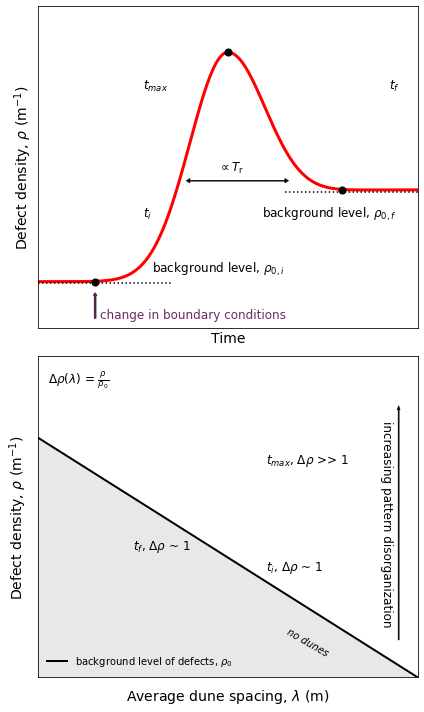

In [20]:
# FIGURE 2

fig, axes = plt.subplots(nrows=2, figsize=(6, 10), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# panel 1: hypothetical rho_0 evolution
ax1 = axes[0]

# defines the curves to plot the red line in the plot
def custom_curve1(x1):
    return 2 + (3.25 - 2) * (1 + np.cos(np.pi * (x1 - 1))) * np.exp(-10 * (x1 - 1)**2)

def custom_curve2(x2):
    return 3 + (3 - 2) * (0.5 + np.cos(np.pi * (x2 - 1))) * np.exp(-10 * (x2 - 1)**2)

x1 = np.linspace(0, 1, 1000)
x2 = np.linspace(1, 2, 1000)

y1 = custom_curve1(x1)
y2 = custom_curve2(x2)

# plot red lines
ax1.plot(x1, y1, color='r', linestyle='-', linewidth=3, zorder=1)
ax1.plot(x2, y2, color='r', linestyle='-', linewidth=3, zorder=1)

# adding p_0 background dashed lines
ax1.axhline(y=1.98, xmin=0, xmax=0.35, color='black', linestyle=':', zorder=2)
ax1.axhline(y=2.98, xmin=0.65, xmax=1, color='black', linestyle=':', zorder=2)

# add text
ax1.text(0.6, 2.1, r'background level, $\rho_{0,i}$', fontsize=12)
ax1.text(1.18, 2.7, r'background level, $\rho_{0,f}$', fontsize=12)
ax1.text(0.325, 1.6, 'change in boundary conditions', color='#702963', fontsize=12)
ax1.text(0.95, 3.2, r'$\propto T_{\mathrm{r}}$', fontsize=12)

ax1.text(0.55, 2.7, r'$t_{i}$', fontsize=12)
ax1.text(1.85, 4.1, r'$t_{f}$', fontsize=12)
ax1.text(0.55, 4.1, r'$t_{max}$', fontsize=12)

# add arrows
ax1.arrow(0.3, 1.6, 0, 0.25, head_width=0.02, width=0.01, facecolor='#702963', edgecolor='black', linewidth=0.5)
ax1.arrow(1.05, 3.1, 0.25, 0, head_width=0.05, head_length=0.02, width=0.01, color='k', linewidth=0.5)
ax1.arrow(1.05, 3.1, -0.25, 0, head_width=0.05, head_length=0.02, width=0.01, color='k', linewidth=0.5)

# add points
ax1.scatter([0.3, 1, 1.6], [2, 4.5, 3], color='k', marker='o', edgecolors='black', linewidth=1, s=50, zorder=3)

# labels and formatting
ax1.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([0, 2])
ax1.set_ylim([1.5, 5])
ax1.set_xlabel('Time', fontsize=14)


# panel 2: hypothetical lambda vs rho
ax2 = axes[1]

# calculate p_0 line
v1 = np.logspace(1, 5, num=4001)
line1 = np.exp(4.4946) * v1**(-2.2375)

# plot p_0 line
ax2.plot(v1, line1, color='k', linestyle='-', linewidth=2, label=r'background level of defects, $\rho_{0}$', zorder=7)
ax2.fill_between(v1, line1, 10**-7, color='lightgray', alpha=0.5, zorder=1)

# add text
ax2.text(10**3.2, 10**-5.0, r'$t_{i}$, $\Delta \rho$ ~ 1', fontsize=12)
ax2.text(10**2.5, 10**-4.6, r'$t_{f}$, $\Delta \rho$ ~ 1', fontsize=12)
ax2.text(10**3.2, 10**-3, r'$t_{max}$, $\Delta \rho$ >> 1', fontsize=12)

ax2.text(10**3.8, 10**-6, 'increasing pattern disorganization', fontsize=12, rotation = 270)
ax2.arrow(10**3.9, 10**-6.3, 0, 10**-2 - 10**-6.3, head_length = 0.002, width = 100, color = 'k', linewidth=0.5)

ax2.text(10**2.05, 10**-1.5, r'$\Delta \rho$($\lambda$) = $\frac{\rho}{\rho_{0}}$', fontsize=12)

ax2.text(10**3.3, 10**(-6.6), 'no dunes', fontsize = 10, style='italic', rotation = -30)


# labels and formatting
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([10**2, 10**4])
ax2.set_ylim([10**-7, 10**-1])

ax2.set_xlabel('Average dune spacing, $\\lambda$ (m)', fontsize=14)
ax2.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=14)
ax2.legend(loc="lower left", frameon=False)

ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax2.set_xticks([])
ax2.set_yticks([])

# make the background of panel 2 transparent
ax2.patch.set_alpha(0)

plt.tight_layout()
# plt.savefig('fig2_rho_0_hypothetical.pdf', bbox_inches='tight', transparent=True))

plt.show()

# gradient background to panel 2 added in Adobe Illustrator

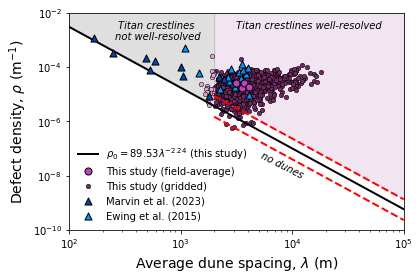

In [19]:
# FIGURE 3

fig, ax = plt.subplots()

# calculate p_0 line
v1 = np.logspace(1, 5, num=4001)
line1 = np.exp(4.4946)*v1**(-2.2375)

# get upper and lower rho_0 error line
v2 = np.logspace(np.log(2000)/np.log(10), 5, num=2001)

line2 = np.exp(4.4946)*0.6*1.2**-2.2375*(v2)**(-2.2375)
line4 = np.exp(4.4946)*1.4/0.8**2.2375*(v2)**(-2.2375)

# get line for < 2000 lambda, used for shaded region
v3 = np.logspace(1, np.log(2000)/np.log(10), num=4001)
line3 = np.exp(4.4946)*(v3)**(-2.2375)

#vertical line at lambda = 2000 m
# plt.axvline(x=2000, ymin=0.57, ymax=1, color='black', linestyle=':', zorder = 11) #, label = '$\\lambda$ = 2000 m'

#shaded regions
plt.fill_between(v2, line4, 1, color='purple', alpha=0.1, zorder = 1) #Titan crestlines well-resolved
plt.fill_between(v3, line3, 1, color='gray', alpha=0.25, zorder = 2) #Titan crestlines not well-resolved

# rho_0 line and error lines
plt.plot(v1, line1, color='k', linestyle='-', linewidth=2, label = r'$\rho_{0} = 89.53 \lambda^{-2.24}$ (this study)', zorder = 7)
plt.plot(v2, line2, color='r', linestyle='--',  linewidth=2, zorder = 8) #label = r'$\rho_{0} = 191.87 \lambda^{-2.24}$',
plt.plot(v2, line4, color='r', linestyle='--',  linewidth=2, zorder = 9) #label = r'$\rho_{0} = 41.66 \lambda^{-2.24}$'

#scatter points
plt.scatter( dunefields['LAMBDA_M'], dunefields['RHO'], color='#BF40BF', edgecolors='black', linewidth=1, marker='o', s=50, label = 'This study (field-average)', zorder = 6)
plt.scatter( filtered_df_over2k['LAMBDA_M'], filtered_df_over2k['RHO'], color='#702963', edgecolors='black', linewidth=0.5, marker='o', s=20, label = 'This study (gridded)', zorder = 3) #'702963'
plt.scatter( filtered_df_under2k['LAMBDA_M'], filtered_df_under2k['RHO'], color='#dea6d4', edgecolors='black', linewidth=0.5, marker='o', s=20, zorder = 4) #'702963'
plt.scatter( M_df['LAMBDA_M'], M_df['RHO'], color='#0047AB', marker='^', edgecolors='black', linewidth=1, s=50, label = 'Marvin et al. (2023)', zorder = 10)
plt.scatter( E_df['LAMBDA_M'], E_df['RHO'], color='#0096FF', marker='^', edgecolors='black', linewidth=1, s=50, label = 'Ewing et al. (2015)', zorder = 5)


# Add labels and legend
plt.xlabel('Average dune spacing, $\\lambda$ (m)', fontsize=14)
plt.ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=14)
plt.legend(loc="lower left", frameon=False)

# add text to plot
plt.text(10**4.15, 10**(-2.6), 'Titan crestlines well-resolved', horizontalalignment='center', fontsize = 10, style='italic')
plt.text(10**2.8, 10**(-3), 'Titan crestlines \nnot well-resolved', horizontalalignment='center', fontsize = 10, style='italic')
plt.text(10**3.7, 10**(-8.1), 'no dunes', fontsize = 10, style='italic', rotation = -27)


# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**2, 10**5])
plt.ylim([10**-10, 10**-2])

# plt.savefig('fig3_spacing_vs_rho.pdf', bbox_inches='tight')
plt.show()

/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/2342572319.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FAKE_LONG'] = filtered_df['LONG_W'].apply(lambda x: 45 - x if x < 45 else 405 - x)
/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/2342572319.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DIST_X_KM'] = filtered_df['FAKE_LONG'] * km_deg
/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/2342572319.py:26: SettingWithCop

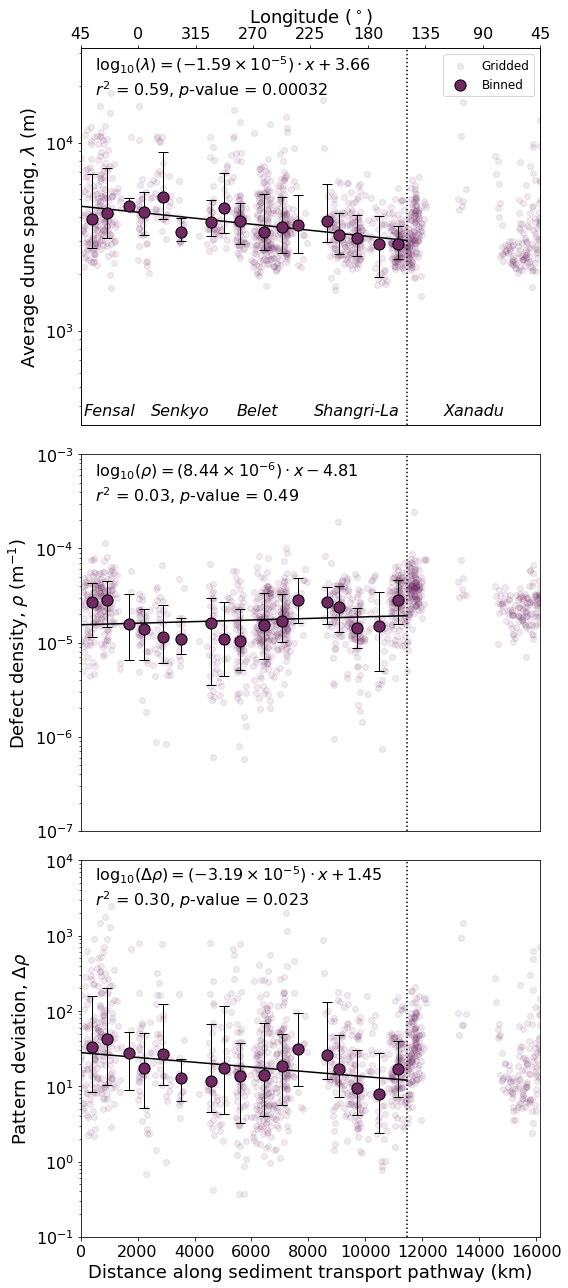

In [13]:
#FIGURE 5

# define values to go from longitude to distance, given Titan's equatorial circumference is 16177 km
titan_circ_km = 16177
titan_deg = 360
km_deg = titan_circ_km / titan_deg

#define bins of 15 degrees
bin_deg = 15
bin_km = bin_deg * km_deg

# define where Xanadu starts
xanadu_start = (405 - 150) * km_deg

# y limits for panel 1
YMIN = 0.1
YMAX = 10**4

# create fake longitude values where 0 degrees is where Xanadu starts for easy distance calculations
filtered_df['FAKE_LONG'] = filtered_df['LONG_W'].apply(lambda x: 45 - x if x < 45 else 405 - x)
filtered_df['DIST_X_KM'] = filtered_df['FAKE_LONG'] * km_deg

# Subset the data for DIST_X_KM from 0 to xanadu_start
subset_df = filtered_df[(filtered_df['DIST_X_KM'] >= 0) & (filtered_df['DIST_X_KM'] <= xanadu_start)]

# bin data
bins = np.arange(0, subset_df['DIST_X_KM'].max() + bin_km, bin_km)
subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # (rows, cols), total figure size

### panel 1

ax = axes[0]

# get mean values/percentiles for each bin
binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'LAMBDA_M': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'LAMBDA_M_LOG_MEAN', 'LAMBDA_M_LOG_P16', 'LAMBDA_M_LOG_P84']



# log transform DELTA_RHO for regression
binned_data['LAMBDA_MEAN'] = 10**(binned_data['LAMBDA_M_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['LAMBDA_M_LOG_P16'])
binned_data['P84'] = 10**(binned_data['LAMBDA_M_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['LAMBDA_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['LAMBDA_MEAN']


# linear regression on the log-transformed binned data
slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['LAMBDA_M_LOG_MEAN'])

# regression line from 0 to xanadu_start
regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)

coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\lambda) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)
stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.5f}".format(formatted_r_squared, formatted_p_value)

# add second x axis for longitude values
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())  # Match the limits of the primary x-axis

# define tick positions for second x axis labels
km_ticks = [0, 2022.125, 4044.25, 6066.375, 8088.5, 10110.625, 12132.75, 14154.875, 16177]
long_labels = [45, 0, 315, 270, 225, 180, 135, 90, 45]  # Corresponding longitude values

ax2.set_xticks(km_ticks)
ax2.set_xticklabels(long_labels, fontsize=16)

# create second x axis label
ax2.set_xlabel('Longitude ($^\circ$)', fontsize=18)

# add text
ax.text(3500, 10**2.55, 'Senkyo', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(6200, 10**2.55, 'Belet', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(9700, 10**2.55, 'Shangri-La', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(1000, 10**2.55, 'Fensal', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text((405-97.5)*km_deg, 10**2.55, 'Xanadu', c='k', fontsize=16, style='italic', horizontalalignment='center')

# scatter points and add line
ax.scatter(filtered_df['DIST_X_KM'], filtered_df['LAMBDA_M'], color='#702963', alpha=0.1, label='Gridded', zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'], color='#702963', edgecolors='black', s=125, label='Binned', zorder=4)

ax.text(500, 10**4.25, equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')
ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xticks([])
ax.set_xlabel('') 

ax.set_ylabel('Average dune spacing, $\\lambda$ (m)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(filtered_df['DIST_X_KM']))
ax.set_ylim(10**2.5, 10**4.5)
ax.legend(fontsize=12)

### panel 2

ax = axes[1]

binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'RHO_LOG_MEAN', 'RHO_LOG_P16', 'RHO_LOG_P84']

binned_data['RHO_MEAN'] = 10**(binned_data['RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 2)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\rho) = ({:.2f} \times 10^{{{}}}) \cdot x {}$".format(coefficient, exponent, formatted_intercept)

stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.2f}".format(formatted_r_squared, formatted_p_value)

ax.text(500, 10**(-3.5), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(filtered_df['DIST_X_KM'], filtered_df['RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)
ax.set_xticks([])
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(filtered_df['DIST_X_KM']))
ax.set_ylim(10**(-7), 10**(-3))


### panel 3
ax = axes[2]


binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'DELTA_RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'DELTA_RHO_LOG_MEAN', 'DELTA_RHO_LOG_P16', 'DELTA_RHO_LOG_P84']


binned_data['DELTA_RHO_MEAN'] = 10**(binned_data['DELTA_RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['DELTA_RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['DELTA_RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['DELTA_RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['DELTA_RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\Delta \rho) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)


stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.3f}".format(formatted_r_squared, formatted_p_value)


ax.text(500, 10**(3.4), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(filtered_df['DIST_X_KM'], filtered_df['DELTA_RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xlabel('Distance along sediment transport pathway (km)', fontsize=18)
ax.set_ylabel('Pattern deviation, $\\Delta \\rho$', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim(0, max(filtered_df['DIST_X_KM']))
ax.set_ylim(10**(-1), 10**4)

plt.subplots_adjust(hspace=0.1)  # reducing space in between panels
plt.tight_layout()

# plt.savefig('fig5_distance_vs_patterns.pdf', bbox_inches='tight')

plt.show()


In [ ]:
# SUPPLEMENTAL TEXT FIGURES

/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/1724472667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LAT_bins'] = pd.cut(abs(filtered_df['LAT']), bins)


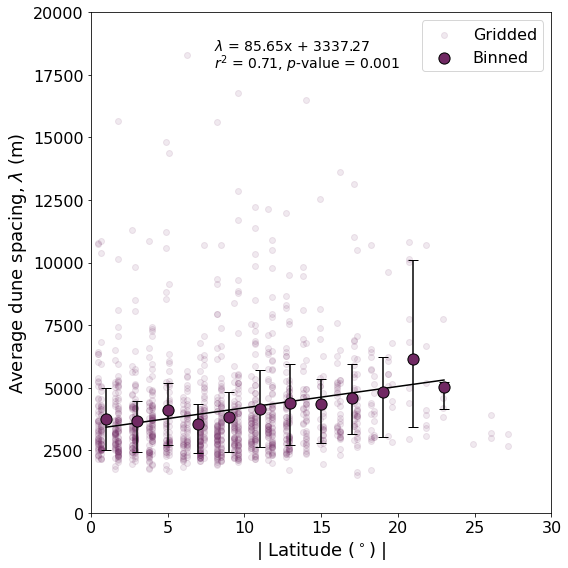

In [16]:
# FIG. S3

# bins go from -30 to 25 deg longitude (extent of dunes) with bins of 5 degrees
bins = np.arange(0, 26, 2)

# calculate center of bins
bin_centers = (bins[:-1] + bins[1:]) / 2

# bin data, get mean spacing value per bin
filtered_df['LAT_bins'] = pd.cut(abs(filtered_df['LAT']), bins)
binned_data = filtered_df.groupby('LAT_bins')['LAMBDA_M'].agg(
    ['mean', lambda x: np.percentile(x, 16), lambda x: np.percentile(x, 84)]
).reset_index()

# rename columns
binned_data.columns = ['LAT_bins', 'mean_LAMBDA_M', 'P16', 'P84']

# use the center of bins for plotting
binned_data['LAT_centers'] = bin_centers

# linear regression
X = binned_data['LAT_centers'].values.reshape(-1, 1)
y = binned_data['mean_LAMBDA_M']
reg = LinearRegression().fit(X, y)

y_pred = reg.predict(X)

# get r^2
r2 = reg.score(X, y)

# get p value
slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['LAT_centers'], y)

plt.figure(figsize=(8, 8))

plt.scatter(abs(filtered_df['LAT']), filtered_df['LAMBDA_M'], color='#702963', alpha=0.1, zorder=1, label = 'Gridded')

plt.errorbar(binned_data['LAT_centers'], binned_data['mean_LAMBDA_M'], 
             yerr=[binned_data['mean_LAMBDA_M'] - binned_data['P16'], 
                   binned_data['P84'] - binned_data['mean_LAMBDA_M']],
             fmt='o', color='#702963', ecolor='k', capsize=5, zorder=3)

plt.scatter(binned_data['LAT_centers'], binned_data['mean_LAMBDA_M'], marker='o', 
            color='#702963', edgecolors='black', s=125, zorder=4, label = 'Binned')

plt.plot(binned_data['LAT_centers'], y_pred, color='black', linestyle='-', zorder=2)

equation_text = f'$\\lambda$ = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}'
r2_pvalue_text = f'R² = {r2:.3f}\np-value = {p_value:.3f}'

stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.3f}".format(r2, p_value)

plt.text(8, 18500, equation_text, fontsize=14, color='black')
plt.text(8, 17750, stats_text, fontsize=14, color='black')

plt.xlabel("| Latitude ($^\circ$) |", fontsize=18)
plt.ylabel('Average dune spacing, $\\lambda$ (m)', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.tight_layout()

# plt.savefig('fig_S3_lat_vs_lambda.pdf', bbox_inches='tight')

plt.show()


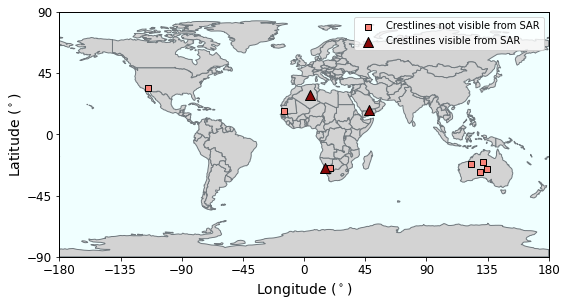

In [17]:
# FIG S4A:

# define degraded and non-degraded data
e_long = M_df.loc[M_df['DEGRADED_USE'] == "N"]
e_long_deg = M_df.loc[M_df['DEGRADED_USE'] == "Y"]

fig, ax = plt.subplots(figsize=(9, 4.5))

e = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='#D3D3D3', edgecolor='#71797E')  # Color it

e.drawmapboundary(fill_color='#F0FFFF', ax=ax)

e.scatter(e_long['LONG'], e_long['LAT'], c='#F88379', edgecolors='black', marker='s', s=40, ax=ax, label = 'Crestlines not visible from SAR')
e.scatter(e_long_deg['LONG'], e_long_deg['LAT'], c='#880808', edgecolors='black', marker='^', s=100, ax=ax, label = 'Crestlines visible from SAR')

plt.xticks(np.arange(-180, 225, step=45), fontsize=12)
plt.yticks(np.arange(-90, 135, step=45), fontsize=12)

plt.xlabel("Longitude ($^\circ$)", fontsize=14)
plt.ylabel("Latitude ($^\circ$)", fontsize=14)

plt.legend(loc = 'upper right')

plt.show()

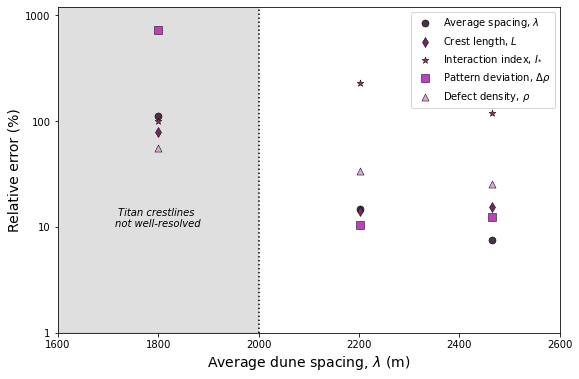

In [18]:
# FIG. S5:

fig, ax = plt.subplots(figsize=(9, 6))

# define relative error
deg_df['LAMBDA_REL_ERR'] = np.log10(abs(deg_df['LAMBDA_M']-deg_df['LAMBDA_M_DEG'])/deg_df['LAMBDA_M'])
deg_df['ISTAR_REL_ERR'] = np.log10(abs(deg_df['Istar']-deg_df['Istar_DEG'])/deg_df['Istar'])
deg_df['CREST_LENGTH_REL_ERR'] = np.log10(abs(deg_df['CREST_LENGTH_M']-deg_df['CREST_LENGTH_M_DEG'])/deg_df['CREST_LENGTH_M'])
deg_df['RHO_REL_ERR'] = np.log10(abs(deg_df['RHO']-deg_df['RHO_DEG'])/deg_df['RHO'])
deg_df['DELTA_RHO_REL_ERR'] = np.log10(abs(deg_df['DELTA_RHO']-deg_df['DELTA_RHO_DEG'])/deg_df['DELTA_RHO'])

# vector from 1000-2000 m
v7 = np.logspace(3, np.log(2000)/np.log(10), num=2001)

#vertical line at lambda = 2000 m
plt.axvline(x=2000, ymin=0, ymax=1, color='black', linestyle=':', zorder = 2) #, label = '$\\lambda$ = 2000 m'

#shaded regions
plt.fill_between(v7, -2, 5, color='gray', alpha=0.25, zorder = 1) #Titan crestlines well-resolved

plt.scatter( deg_df['LAMBDA_M'], deg_df['LAMBDA_REL_ERR'], color='#483248', edgecolors='black', linewidth=0.5, marker='o', s=50, label = 'Average spacing, $\\lambda$', zorder = 2)
plt.scatter( deg_df['LAMBDA_M'], deg_df['CREST_LENGTH_REL_ERR'], color='#702963', edgecolors='black', linewidth=0.5, marker='d', s=50, label = 'Crest length, $\it{L}$', zorder = 3) #'702963'
plt.scatter( deg_df['LAMBDA_M'], deg_df['ISTAR_REL_ERR'], color='#9F2B68', edgecolors='black', linewidth=0.5, marker='*', s=50, label = 'Interaction index, 'r'$I_{*}$', zorder = 5)
plt.scatter( deg_df['LAMBDA_M'], deg_df['DELTA_RHO_REL_ERR'], color='#BF40BF', edgecolors='black', linewidth=0.5, marker='s', s=50, label = 'Pattern deviation, 'r'$\Delta \rho$', zorder = 1) #'702963'
plt.scatter( deg_df['LAMBDA_M'], deg_df['RHO_REL_ERR'], color='#dea6d4', edgecolors='black', linewidth=0.5, marker='^', s=50, label = 'Defect density, $\\rho$', zorder = 4) #'702963'


plt.text(1800, -1, 'Titan crestlines \nnot well-resolved', horizontalalignment='center', fontsize=10, style = 'italic')

plt.xlabel('Average dune spacing, $\\lambda$ (m)', fontsize = 14) 
plt.ylabel(r'Relative error (%)', fontsize = 14)

ax.set_yticks([np.log10(0.01), np.log10(0.1), np.log10(1), np.log10(10), np.log10(100)], fontsize = 12)
ax.set_yticklabels(('1', '10', '100', '1000', '10000'))

plt.xlim([1600, 2600])
plt.ylim([np.log10(0.01), np.log10(12)])

plt.legend(loc = 'upper right')
# plt.savefig('figS5_log10_error.pdf', bbox_inches='tight')


plt.show()

/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/288416814.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


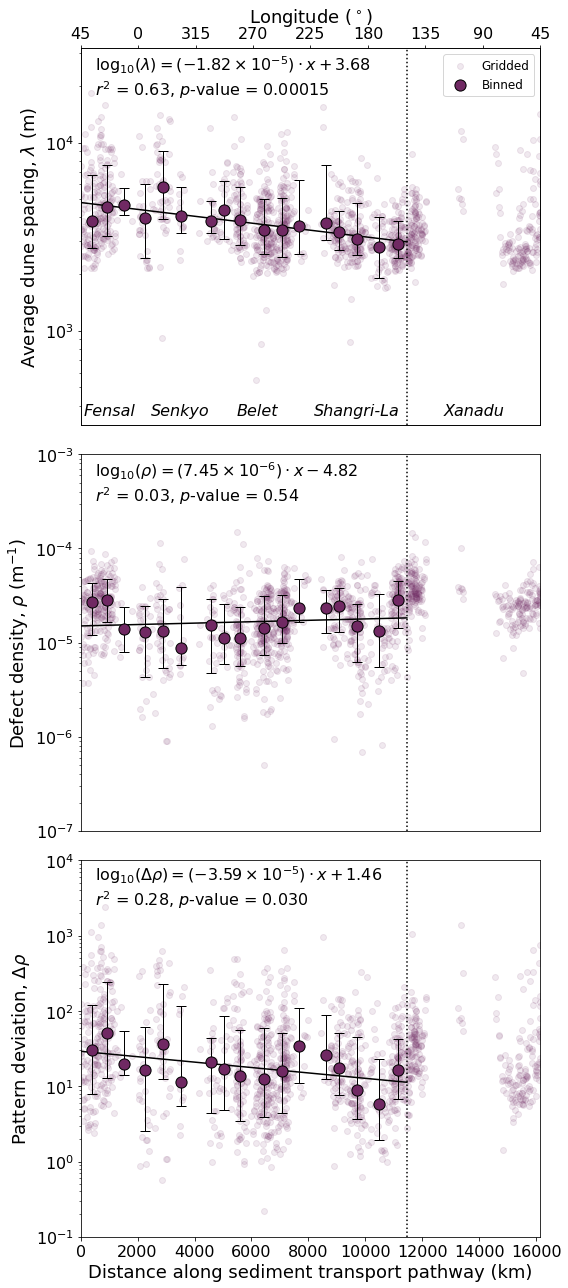

In [25]:
#FIGURE S6

# read in data

path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/marvin_etal_2024_grid50km_mercator_processed.csv'
data = pd.read_csv(path)
df = pd.DataFrame(data)

# define values to go from longitude to distance, given Titan's equatorial circumference is 16177 km
titan_circ_km = 16177
titan_deg = 360
km_deg = titan_circ_km / titan_deg

#define bins of 15 degrees
bin_deg = 15
bin_km = bin_deg * km_deg

# define where Xanadu starts
xanadu_start = (405 - 150) * km_deg

# y limits for panel 1
YMIN = 0.1
YMAX = 10**4

# create fake longitude values where 0 degrees is where Xanadu starts for easy distance calculations
df['FAKE_LONG'] = df['LONG_W'].apply(lambda x: 45 - x if x < 45 else 405 - x)
df['DIST_X_KM'] = df['FAKE_LONG'] * km_deg

# Subset the data for DIST_X_KM from 0 to xanadu_start
subset_df = df[(df['DIST_X_KM'] >= 0) & (df['DIST_X_KM'] <= xanadu_start)]

# bin data
bins = np.arange(0, subset_df['DIST_X_KM'].max() + bin_km, bin_km)
subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # (rows, cols), total figure size

### panel 1

ax = axes[0]

# get mean values/percentiles for each bin
binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'LAMBDA_M': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'LAMBDA_M_LOG_MEAN', 'LAMBDA_M_LOG_P16', 'LAMBDA_M_LOG_P84']



# log transform DELTA_RHO for regression
binned_data['LAMBDA_MEAN'] = 10**(binned_data['LAMBDA_M_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['LAMBDA_M_LOG_P16'])
binned_data['P84'] = 10**(binned_data['LAMBDA_M_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['LAMBDA_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['LAMBDA_MEAN']


# linear regression on the log-transformed binned data
slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['LAMBDA_M_LOG_MEAN'])

# regression line from 0 to xanadu_start
regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)

coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\lambda) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)
stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.5f}".format(formatted_r_squared, formatted_p_value)

# add second x axis for longitude values
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())  # Match the limits of the primary x-axis

# define tick positions for second x axis labels
km_ticks = [0, 2022.125, 4044.25, 6066.375, 8088.5, 10110.625, 12132.75, 14154.875, 16177]
long_labels = [45, 0, 315, 270, 225, 180, 135, 90, 45]  # Corresponding longitude values

ax2.set_xticks(km_ticks)
ax2.set_xticklabels(long_labels, fontsize=16)

# create second x axis label
ax2.set_xlabel('Longitude ($^\circ$)', fontsize=18)

# add text
ax.text(3500, 10**2.55, 'Senkyo', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(6200, 10**2.55, 'Belet', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(9700, 10**2.55, 'Shangri-La', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(1000, 10**2.55, 'Fensal', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text((405-97.5)*km_deg, 10**2.55, 'Xanadu', c='k', fontsize=16, style='italic', horizontalalignment='center')

# scatter points and add line
ax.scatter(df['DIST_X_KM'], df['LAMBDA_M'], color='#702963', alpha=0.1, label='Gridded', zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'], color='#702963', edgecolors='black', s=125, label='Binned', zorder=4)

ax.text(500, 10**4.25, equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')
ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xticks([])
ax.set_xlabel('') 

ax.set_ylabel('Average dune spacing, $\\lambda$ (m)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**2.5, 10**4.5)
ax.legend(fontsize=12)

### panel 2

ax = axes[1]

binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'RHO_LOG_MEAN', 'RHO_LOG_P16', 'RHO_LOG_P84']

binned_data['RHO_MEAN'] = 10**(binned_data['RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 2)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\rho) = ({:.2f} \times 10^{{{}}}) \cdot x {}$".format(coefficient, exponent, formatted_intercept)

stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.2f}".format(formatted_r_squared, formatted_p_value)

ax.text(500, 10**(-3.5), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)
ax.set_xticks([])
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-7), 10**(-3))


### panel 3
ax = axes[2]


binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'DELTA_RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'DELTA_RHO_LOG_MEAN', 'DELTA_RHO_LOG_P16', 'DELTA_RHO_LOG_P84']


binned_data['DELTA_RHO_MEAN'] = 10**(binned_data['DELTA_RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['DELTA_RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['DELTA_RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['DELTA_RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['DELTA_RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\Delta \rho) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)


stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.3f}".format(formatted_r_squared, formatted_p_value)


ax.text(500, 10**(3.4), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['DELTA_RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xlabel('Distance along sediment transport pathway (km)', fontsize=18)
ax.set_ylabel('Pattern deviation, $\\Delta \\rho$', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-1), 10**4)

plt.subplots_adjust(hspace=0.1)  # reducing space in between panels
plt.tight_layout()

# plt.savefig('figS6_distance_vs_patterns_mercator_50km.pdf', bbox_inches='tight')

plt.show()


/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/3713625551.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


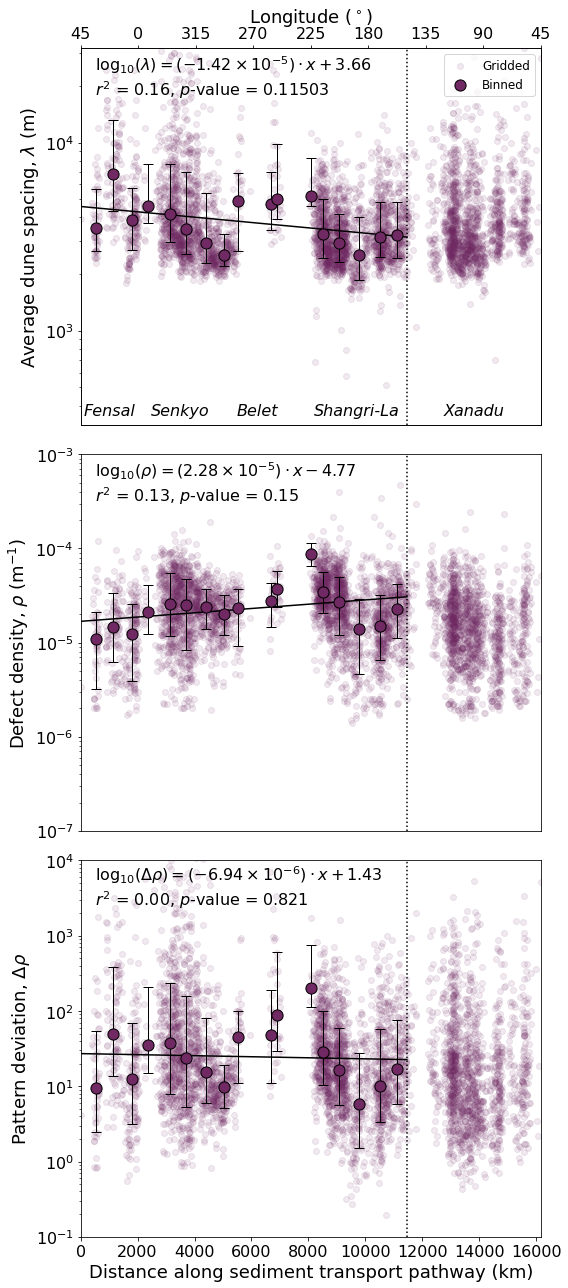

In [26]:
#FIGURE S7

# read in data
path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/marvin_etal_2024_data_grid25km_processed.csv'
data = pd.read_csv(path)
df = pd.DataFrame(data)

# define values to go from longitude to distance, given Titan's equatorial circumference is 16177 km
titan_circ_km = 16177
titan_deg = 360
km_deg = titan_circ_km / titan_deg

#define bins of 15 degrees
bin_deg = 15
bin_km = bin_deg * km_deg

# define where Xanadu starts
xanadu_start = (405 - 150) * km_deg

# y limits for panel 1
YMIN = 0.1
YMAX = 10**4

df['FAKE_LONG'] = df['LONG'].apply(lambda x: 45 - x if x < 45 else 405 - x)
df['DIST_X_KM'] = df['FAKE_LONG'] * km_deg


# Subset the data for DIST_X_KM from 0 to xanadu_start
subset_df = df[(df['DIST_X_KM'] >= 0) & (df['DIST_X_KM'] <= xanadu_start)]

# bin data
bins = np.arange(0, subset_df['DIST_X_KM'].max() + bin_km, bin_km)
subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # (rows, cols), total figure size

### panel 1

ax = axes[0]

# get mean values/percentiles for each bin
binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'LAMBDA_M': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'LAMBDA_M_LOG_MEAN', 'LAMBDA_M_LOG_P16', 'LAMBDA_M_LOG_P84']



# log transform DELTA_RHO for regression
binned_data['LAMBDA_MEAN'] = 10**(binned_data['LAMBDA_M_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['LAMBDA_M_LOG_P16'])
binned_data['P84'] = 10**(binned_data['LAMBDA_M_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['LAMBDA_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['LAMBDA_MEAN']


# linear regression on the log-transformed binned data
slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['LAMBDA_M_LOG_MEAN'])

# regression line from 0 to xanadu_start
regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)

coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\lambda) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)
stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.5f}".format(formatted_r_squared, formatted_p_value)

# add second x axis for longitude values
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())  # Match the limits of the primary x-axis

# define tick positions for second x axis labels
km_ticks = [0, 2022.125, 4044.25, 6066.375, 8088.5, 10110.625, 12132.75, 14154.875, 16177]
long_labels = [45, 0, 315, 270, 225, 180, 135, 90, 45]  # Corresponding longitude values

ax2.set_xticks(km_ticks)
ax2.set_xticklabels(long_labels, fontsize=16)

# create second x axis label
ax2.set_xlabel('Longitude ($^\circ$)', fontsize=18)

# add text
ax.text(3500, 10**2.55, 'Senkyo', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(6200, 10**2.55, 'Belet', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(9700, 10**2.55, 'Shangri-La', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(1000, 10**2.55, 'Fensal', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text((405-97.5)*km_deg, 10**2.55, 'Xanadu', c='k', fontsize=16, style='italic', horizontalalignment='center')

# scatter points and add line
ax.scatter(df['DIST_X_KM'], df['LAMBDA_M'], color='#702963', alpha=0.1, label='Gridded', zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'], color='#702963', edgecolors='black', s=125, label='Binned', zorder=4)

ax.text(500, 10**4.25, equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')
ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xticks([])
ax.set_xlabel('') 

ax.set_ylabel('Average dune spacing, $\\lambda$ (m)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**2.5, 10**4.5)
ax.legend(fontsize=12, loc = 'upper right')

### panel 2

ax = axes[1]

binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'RHO_LOG_MEAN', 'RHO_LOG_P16', 'RHO_LOG_P84']

binned_data['RHO_MEAN'] = 10**(binned_data['RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 2)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\rho) = ({:.2f} \times 10^{{{}}}) \cdot x {}$".format(coefficient, exponent, formatted_intercept)

stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.2f}".format(formatted_r_squared, formatted_p_value)

ax.text(500, 10**(-3.5), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)
ax.set_xticks([])
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-7), 10**(-3))


### panel 3
ax = axes[2]


binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'DELTA_RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'DELTA_RHO_LOG_MEAN', 'DELTA_RHO_LOG_P16', 'DELTA_RHO_LOG_P84']


binned_data['DELTA_RHO_MEAN'] = 10**(binned_data['DELTA_RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['DELTA_RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['DELTA_RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['DELTA_RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['DELTA_RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\Delta \rho) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)


stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.3f}".format(formatted_r_squared, formatted_p_value)


ax.text(500, 10**(3.4), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['DELTA_RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xlabel('Distance along sediment transport pathway (km)', fontsize=18)
ax.set_ylabel('Pattern deviation, $\\Delta \\rho$', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-1), 10**4)

plt.subplots_adjust(hspace=0.1)  # reducing space in between panels
plt.tight_layout()

# plt.savefig('figS7_patterns_vs_distance_equirectangular_25km.pdf', bbox_inches='tight')

plt.show()


/var/folders/4m/0hkvj9s15sd7cpzjb1phwy0m0000gn/T/ipykernel_78777/702724781.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


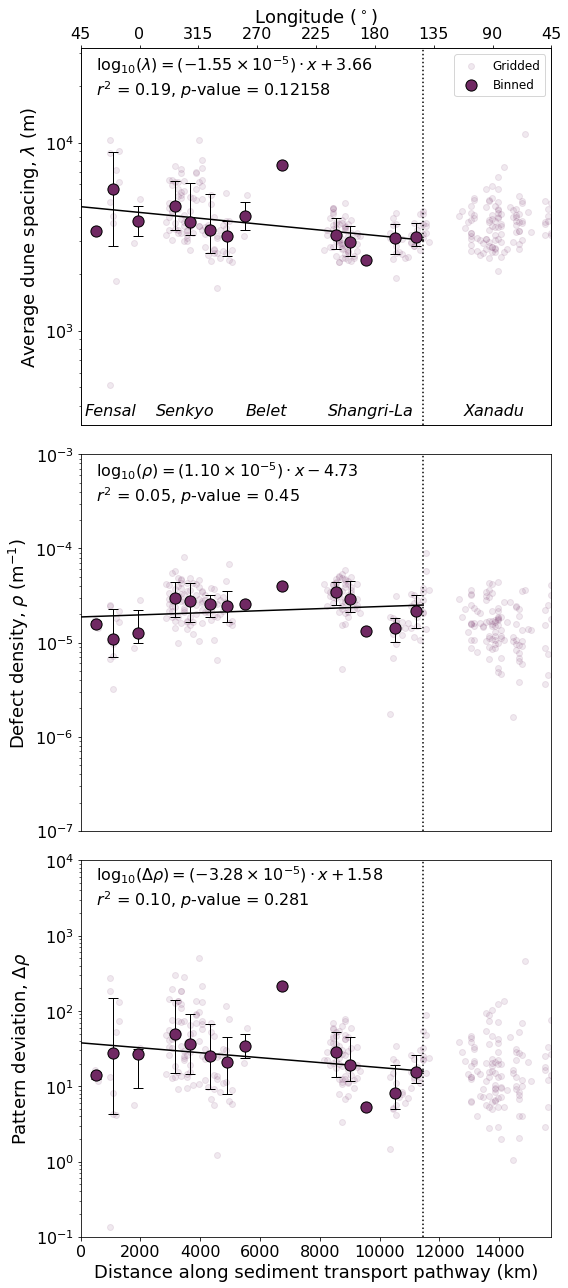

In [27]:
#FIGURE S8

# read in data
path = '/Users/michaelmarvin/Library/CloudStorage/OneDrive-Stanford/Research Work/Titan_Degradation/Code/marvin_etal_2024_GRL/marvin_etal_2024_data_grid100km_processed.csv'
data = pd.read_csv(path)
df = pd.DataFrame(data)

# define values to go from longitude to distance, given Titan's equatorial circumference is 16177 km
titan_circ_km = 16177
titan_deg = 360
km_deg = titan_circ_km / titan_deg

#define bins of 15 degrees
bin_deg = 15
bin_km = bin_deg * km_deg

# define where Xanadu starts
xanadu_start = (405 - 150) * km_deg

# y limits for panel 1
YMIN = 0.1
YMAX = 10**4

df['FAKE_LONG'] = df['LONG'].apply(lambda x: 45 - x if x < 45 else 405 - x)
df['DIST_X_KM'] = df['FAKE_LONG'] * km_deg


# Subset the data for DIST_X_KM from 0 to xanadu_start
subset_df = df[(df['DIST_X_KM'] >= 0) & (df['DIST_X_KM'] <= xanadu_start)]

# bin data
bins = np.arange(0, subset_df['DIST_X_KM'].max() + bin_km, bin_km)
subset_df['BIN'] = np.digitize(subset_df['DIST_X_KM'], bins) - 1


fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # (rows, cols), total figure size

### panel 1

ax = axes[0]

# get mean values/percentiles for each bin
binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'LAMBDA_M': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'LAMBDA_M_LOG_MEAN', 'LAMBDA_M_LOG_P16', 'LAMBDA_M_LOG_P84']



# log transform DELTA_RHO for regression
binned_data['LAMBDA_MEAN'] = 10**(binned_data['LAMBDA_M_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['LAMBDA_M_LOG_P16'])
binned_data['P84'] = 10**(binned_data['LAMBDA_M_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['LAMBDA_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['LAMBDA_MEAN']


# linear regression on the log-transformed binned data
slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['LAMBDA_M_LOG_MEAN'])

# regression line from 0 to xanadu_start
regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)

coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\lambda) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)
stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.5f}".format(formatted_r_squared, formatted_p_value)

# add second x axis for longitude values
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())  # Match the limits of the primary x-axis

# define tick positions for second x axis labels
km_ticks = [0, 2022.125, 4044.25, 6066.375, 8088.5, 10110.625, 12132.75, 14154.875, 16177]
long_labels = [45, 0, 315, 270, 225, 180, 135, 90, 45]  # Corresponding longitude values

ax2.set_xticks(km_ticks)
ax2.set_xticklabels(long_labels, fontsize=16)

# create second x axis label
ax2.set_xlabel('Longitude ($^\circ$)', fontsize=18)

# add text
ax.text(3500, 10**2.55, 'Senkyo', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(6200, 10**2.55, 'Belet', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(9700, 10**2.55, 'Shangri-La', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text(1000, 10**2.55, 'Fensal', c='k', fontsize=16, style='italic', horizontalalignment='center')
ax.text((405-97.5)*km_deg, 10**2.55, 'Xanadu', c='k', fontsize=16, style='italic', horizontalalignment='center')

# scatter points and add line
ax.scatter(df['DIST_X_KM'], df['LAMBDA_M'], color='#702963', alpha=0.1, label='Gridded', zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['LAMBDA_MEAN'], color='#702963', edgecolors='black', s=125, label='Binned', zorder=4)

ax.text(500, 10**4.25, equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')
ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xticks([])
ax.set_xlabel('') 

ax.set_ylabel('Average dune spacing, $\\lambda$ (m)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**2.5, 10**4.5)
ax.legend(fontsize=12, loc = 'upper right')

### panel 2

ax = axes[1]

binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'RHO_LOG_MEAN', 'RHO_LOG_P16', 'RHO_LOG_P84']

binned_data['RHO_MEAN'] = 10**(binned_data['RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 2)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\rho) = ({:.2f} \times 10^{{{}}}) \cdot x {}$".format(coefficient, exponent, formatted_intercept)

stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.2f}".format(formatted_r_squared, formatted_p_value)

ax.text(500, 10**(-3.5), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)
ax.set_xticks([])
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('Defect density, $\\rho$ (m$^{-1}$)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-7), 10**(-3))


### panel 3
ax = axes[2]


binned_data = subset_df.groupby('BIN').agg({
    'DIST_X_KM': 'mean',
    'DELTA_RHO': [lambda x: np.percentile(np.log10(x), 50), lambda x: np.percentile(np.log10(x), 16), lambda x: np.percentile(np.log10(x), 84)]
}).dropna()
binned_data.columns = ['DIST_X_KM', 'DELTA_RHO_LOG_MEAN', 'DELTA_RHO_LOG_P16', 'DELTA_RHO_LOG_P84']


binned_data['DELTA_RHO_MEAN'] = 10**(binned_data['DELTA_RHO_LOG_MEAN'])
binned_data['P16'] = 10**(binned_data['DELTA_RHO_LOG_P16'])
binned_data['P84'] = 10**(binned_data['DELTA_RHO_LOG_P84'])

binned_data['YERR_LOW'] = binned_data['DELTA_RHO_MEAN'] - binned_data['P16']
binned_data['YERR_HIGH'] = binned_data['P84'] - binned_data['DELTA_RHO_MEAN']

slope, intercept, r_value, p_value, std_err = stats.linregress(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_LOG_MEAN'])

regression_x = np.linspace(0, xanadu_start, 100)
regression_log_y = slope * regression_x + intercept
regression_y = (10**regression_log_y)


coefficient = round(slope / (10 ** np.floor(np.log10(abs(slope)))), 2)
exponent = int(np.floor(np.log10(abs(slope))))

formatted_intercept = round(intercept, 2)
formatted_p_value = round(p_value, 5)
formatted_r_squared = round(r_value**2, 2)

equation_text = r"$\log_{{10}}(\Delta \rho) = ({:.2f} \times 10^{{{}}}) \cdot x + {}$".format(coefficient, exponent, formatted_intercept)


stats_text = r"$r^2$ = {:.2f}, $p$-value = {:.3f}".format(formatted_r_squared, formatted_p_value)


ax.text(500, 10**(3.4), equation_text + "\n" + stats_text, c='k', fontsize=16, horizontalalignment='left')


ax.scatter(df['DIST_X_KM'], df['DELTA_RHO'], color='#702963', alpha=0.1, zorder=1)
ax.plot(regression_x, regression_y, color='k', zorder=2)
ax.errorbar(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'],
            yerr=[binned_data['YERR_LOW'], binned_data['YERR_HIGH']],
            fmt='o', markersize=6, color='#702963', ecolor='black', elinewidth=1, capsize=5, zorder=3)
ax.scatter(binned_data['DIST_X_KM'], binned_data['DELTA_RHO_MEAN'], color='#702963', edgecolors='black', s=125, zorder=4)

ax.axvline(x=(405 - 150) * km_deg, color='black', linestyle=':', zorder=1)

ax.set_xlabel('Distance along sediment transport pathway (km)', fontsize=18)
ax.set_ylabel('Pattern deviation, $\\Delta \\rho$', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim(0, max(df['DIST_X_KM']))
ax.set_ylim(10**(-1), 10**4)

plt.subplots_adjust(hspace=0.1)  # reducing space in between panels
plt.tight_layout()

# plt.savefig('figS8_patterns_vs_distance_equirectangular_100km.pdf', bbox_inches='tight')

plt.show()
